<a href="https://colab.research.google.com/github/vspvikram/AML_project/blob/main/FINAL_COMPILED_AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
class Tokenizer():
    
    def __init__(self):
        self.word_index = {}
        self.index_word = {0: "<start>", 1: "<end>"}
        self.vocab_size = 2
        
        
    def fit(self, arr):
        self.word_index = {}
        self.index_word = {0: "<start>", 1: "<end>"}
        self.vocab_size = 2
        
        for word in arr:
            if word not in self.word_index:
                self.index_word[self.vocab_size] = word
                self.word_index[word] = self.vocab_size
                self.vocab_size += 1
                    
    def transform(self, sentence):
        return [0] + [self.word_index[word] for word in sentence] + [1]
    
    def reverse_transform(self, encoded_sentence):
        return [self.index_word[num] for num in encoded_sentence[1:-1]]

In [2]:
import os
from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision import transforms

class ImgCapDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.img_dir = img_dir
        self.image_transform = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_1 = os.path.join(self.img_dir, self.df.iloc[idx]["Image1"] + ".png")
        img_1 = Image.open(img_1)
        img_1 = self.image_transform(img_1)
        
        img_2 = os.path.join(self.img_dir, self.df.iloc[idx]["Image2"] + ".png")
        img_2 = Image.open(img_2)
        img_2 = self.image_transform(img_2)
        
        caption = torch.LongTensor(self.df.iloc[idx]["CaptionSeq"])

        return img_1, img_2, caption

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16
from torchvision.models import densenet121

class CNN_Encoder(nn.Module):
    
    def __init__(self):
        super(CNN_Encoder, self).__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding='same')
        self.fc = nn.Linear(256*256*16, 128)

        self.conv2 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding='same')
        self.fc2 = nn.Linear(256*256*16, 128)

    def forward(self, x1, x2):
        x1 = F.relu(self.conv(x1))
        x1 = F.max_pool2d(x1, 2)
        x1 = torch.flatten(x1, 1)
        x1 = self.fc(x1)

        x2 = F.relu(self.conv2(x2))
        x2 = F.max_pool2d(x2, 2)
        x2 = torch.flatten(x2, 1)
        x2 = self.fc2(x2)

        return torch.cat((x1, x2), 1)

class SCNN_Encoder(nn.Module):

    def __init__(self):
        super(SCNN_Encoder, self).__init__()
        self.depthwise = nn.Conv2d(3, 3, kernel_size=3, groups=3, padding=1)
        self.pointwise = nn.Conv2d(3, 16, kernel_size=1)
        self.fc = nn.Linear(256*256*16, 128)
    
        self.depthwise2 = nn.Conv2d(3, 3, kernel_size=3, groups=3, padding=1)
        self.pointwise2 = nn.Conv2d(3, 16, kernel_size=1)
        self.fc2 = nn.Linear(256*256*16, 128)

    def forward(self, x1, x2):
        x1 = F.relu(self.depthwise(x1))
        x1 = F.relu(self.pointwise(x1))
        x1 = F.max_pool2d(x1, 2)
        x1 = torch.flatten(x1, 1)
        x1 = self.fc(x1)

        x2 = F.relu(self.depthwise(x2))
        x2 = F.relu(self.pointwise(x2))
        x2 = F.max_pool2d(x2, 2)
        x2 = torch.flatten(x2, 1)
        x2 = self.fc2(x2)
        return torch.cat((x1, x2), 1)
    
class VGG_Encoder(nn.Module):
    
    def __init__(self):
        super(VGG_Encoder, self).__init__()
        self.vgg1 = vgg16(pretrained=True)
        seq1 = list(self.vgg1.classifier)
        seq1[-1] = nn.Linear(4096, 1024, bias=True)
        seq1.append(nn.ReLU(inplace=True))
        seq1.append(nn.Dropout(p=0.5, inplace=False))
        seq1.append(nn.Linear(1024, 128, bias=True))
        self.vgg1.classifier = nn.Sequential(*seq1)
        
        for param in self.vgg1.features.parameters():
            param.requires_grad = False
        
        self.vgg2 = vgg16(pretrained=True)
        seq2 = list(self.vgg2.classifier)
        seq2[-1] = nn.Linear(4096, 1024, bias=True)
        seq2.append(nn.ReLU(inplace=True))
        seq2.append(nn.Dropout(p=0.5, inplace=False))
        seq2.append(nn.Linear(1024, 128, bias=True))
        self.vgg2.classifier = nn.Sequential(*seq2)
        
        for param in self.vgg2.features.parameters():
            param.requires_grad = False
        
    def forward(self, x1, x2):
        
        x1 = self.vgg1(x1)
        x2 = self.vgg2(x2)
        
        return torch.cat((x1, x2), 1)
    
class DN_Encoder(nn.Module):
    
    def __init__(self):
        super(DN_Encoder, self).__init__()
        self.dn1 = densenet121(pretrained=True)
        self.dn1.classifier = nn.Linear(1024, 128, bias=True)
        
        for param in self.dn1.features.parameters():
            param.requires_grad = False
        
        self.dn2 = densenet121(pretrained=True)
        self.dn2.classifier = nn.Linear(1024, 128, bias=True)
        
        for param in self.dn2.features.parameters():
            param.requires_grad = False
        
    def forward(self, x1, x2):
        
        x1 = self.dn1(x1)
        x2 = self.dn2(x2)
        
        return torch.cat((x1, x2), 1)
        
class ChexNet_DN_Encoder(nn.Module):
    
    def __init__(self):
        super(ChexNet_DN_Encoder, self).__init__()
        self.dn1 = densenet121(pretrained=True)
        #model = model_class.from_pretrained(pretrained_weights, force_download=True)
        #self.dn1.load_state_dict(torch.load("m-30012020-104001.pth.tar"))
        checkpoint = torch.load("m-30012020-104001.pth.tar")
        self.dn1.load_state_dict(checkpoint['state_dict'],strict=False )
        self.dn1.classifier = nn.Linear(1024, 128, bias=True)
        
        for param in self.dn1.features.parameters():
            param.requires_grad = False
        
        self.dn2 = densenet121(pretrained=True)
        self.dn2.classifier = nn.Linear(1024, 128, bias=True)
        
        for param in self.dn2.features.parameters():
            param.requires_grad = False
        
    def forward(self, x1, x2):
        
        x1 = self.dn1(x1)
        x2 = self.dn2(x2)
        
        return torch.cat((x1, x2), 1)

class RNN_Decoder(nn.Module):

    def __init__(self, embed_size, hidden_size, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTMCell(embed_size, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, caption):

        cap = torch.transpose(self.embed(caption), 0, 1)
        output = torch.empty((caption.size(0), caption.size(1), self.vocab_size))

        for i in range(caption.size(1)):

            if i == 0:
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                h = torch.autograd.Variable(torch.zeros(x.size(0), self.hidden_size)).to(device)
                c = torch.autograd.Variable(torch.zeros(x.size(0), self.hidden_size)).to(device)
                h, c = self.rnn(x, (h ,c))
            else:
                h, c = self.rnn(cap[i,:,:], (h, c))

            output[:,i,:] = self.fc(h)

        return output

In [4]:
!pip install biobert-embedding

     |████████████████████████████████| 748.9 MB 700 bytes/s 
     |████████████████████████████████| 123 kB 54.9 MB/s 
     |████████████████████████████████| 131 kB 54.2 MB/s 
     |████████████████████████████████| 79 kB 8.3 MB/s 
     |████████████████████████████████| 8.4 MB 32.6 MB/s 
     |████████████████████████████████| 138 kB 45.8 MB/s 
     |████████████████████████████████| 127 kB 52.2 MB/s 
  Created wheel for biobert-embedding: filename=biobert_embedding-0.1.2-py3-none-any.whl size=5701 sha256=2f1ff27f3017cb4fae5bad207c3e38e7e1b5861481fe61bc30c42aacf0f168a5
  Stored in directory: /root/.cache/pip/wheels/67/26/c2/176e174845e1612a5d607eea1d1876e2c9aca2b5654a5cd681
Successfully built biobert-embedding
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import cosine
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from biobert_embedding.embedding import BiobertEmbedding

class BaseModel():
    
    def __init__(self, train_df, test_df,image_address, sentence_length, vocab_size, epoch, encoder_name):
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.df = df.sample(frac=1).reset_index(drop=True)

        test_df = test_df.sample(frac=1).reset_index(drop=True)
        train_df= train_df.sample(frac=1).reset_index(drop=True)
        train_df, val_df = self.train_val_split(train_df)
        
        train_ds = ImgCapDataset(train_df, image_address)
        val_ds = ImgCapDataset(val_df, image_address)
        test_ds = ImgCapDataset(test_df, image_address)
        
        self.train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
        self.val_dl = DataLoader(val_ds, batch_size=16, shuffle=True)
        self.test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)
        
        self.EPOCH = epoch
        
        if encoder_name == "CNN":
            self.encoder = CNN_Encoder()
        elif encoder_name == "SCNN":
            self.encoder = SCNN_Encoder()
        elif encoder_name == "VGG":
            self.encoder = VGG_Encoder()
        elif encoder_name == "DenseNet":
            self.encoder = DN_Encoder()
        elif encoder_name == 'ChexNet':
            self.encoder = ChexNet_DN_Encoder()
        self.decoder = RNN_Decoder(256, sentence_length, vocab_size)
        
        self.encoder = self.encoder.to(device)
        self.decoder = self.decoder.to(device)
        
        self.encoder_optim = torch.optim.Adam(self.encoder.parameters(), 0.0001)
        self.decoder_optim = torch.optim.Adam(self.decoder.parameters(), 0.0001)
        self.LOSS = torch.nn.CrossEntropyLoss()
        
    def train_val_split(self, df):

        split = 4*len(df)//5
        train = df.iloc[:split,:]
        val = df.iloc[split:,:]
        return train, val
    
    def train(self):
        self._training_loop(
            self.EPOCH, self.encoder, self.decoder, self.encoder_optim, 
            self.decoder_optim, self.LOSS, self.train_dl, self.val_dl
        )
        
    def _training_loop(self, epochs, encoder, decoder, encoder_optimizer, decoder_optimizer, loss_f, train_loader, val_loader):
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        for epoch in range(epochs):
            loss_train = 0.0
            for x1, x2, y in train_loader:
                x1 = x1.to(device)
                x2 = x2.to(device)
                y = y.to(device)
                
                out = encoder(x1, x2)
                out = decoder(out, y)
                out = out.to(device)
                loss = loss_f(torch.flatten(out, 0, 1), torch.flatten(y))

                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()
                loss.backward()
                encoder_optimizer.step()
                decoder_optimizer.step()
                loss_train += loss.item()
            
            with torch.no_grad():
                loss_val = 0.0
                for x1, x2, y in val_loader:
                    x1 = x1.to(device)
                    x2 = x2.to(device)
                    y = y.to(device)

                    out = encoder(x1, x2)
                    out = decoder(out, y)
                    out = out.to(device)
                    loss = loss_f(torch.flatten(out, 0, 1), torch.flatten(y))
                    loss_val += loss.item()
                print("Epoch", epoch, "Train Loss", loss_train/len(train_loader), "Validation Loss", loss_val/len(val_loader))
    
    def sample(self, tokenizer):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        x1, x2, c = next(iter(self.test_dl))
        x1 = x1.to(device)
        x2 = x2.to(device)
        c = c.to(device)
        out1 = self.encoder.forward(x1, x2)
        out2 = self.decoder.forward(out1, c)
        encoded_out = torch.argmax(out2, dim=2).cpu().detach().numpy()

        decoded_out = " ".join([tokenizer.index_word[x] for x in encoded_out[0] if x not in (0, 1)])
            
        c = c.cpu().detach().numpy()
            
        real = " ".join([tokenizer.index_word[x] for x in c[0] if x not in (0, 1)])

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(x1[0].permute(1, 2, 0).cpu().detach().numpy())
        ax[1].imshow(x2[0].permute(1, 2, 0).cpu().detach().numpy())
        plt.show()
        print("Prediction:", decoded_out)
        print("Caption:", real)
        
    def evaluate(self, tokenizer):
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        dist = []
        for x1, x2, c in self.test_dl:
            x1 = x1.to(device)
            x2 = x2.to(device)
            c = c.to(device)
            out1 = self.encoder.forward(x1, x2)
            out2 = self.decoder.forward(out1, c)
            encoded_out = torch.argmax(out2, dim=2).cpu().detach().numpy()

            decoded_out = " ".join([tokenizer.index_word[x] for x in encoded_out[0] if x not in (0, 1)])
            c = c.cpu().detach().numpy()
            real = " ".join([tokenizer.index_word[x] for x in c[0] if x not in (0, 1)])

            biobert = BiobertEmbedding()
            preds = biobert.sentence_vector(decoded_out)
            caps = biobert.sentence_vector(real)
            dist.append(cosine(preds, caps))
            
        return np.mean(dist)
        

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torch.utils.data import DataLoader
from torchtext.data.metrics import bleu_score

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')
#drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [27]:
df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/input.csv")
df = df[["Image1", "Image2", "Clean_capt"]]
df.columns = ["Image1", "Image2", "Caption"]
print(df.shape)
df.head()

(4017, 3)


,Image1,Image2,Caption
0,CXR162_IM-0401-1001,CXR162_IM-0401-2001,normal chest
1,CXR1390_IM-0249-1001,CXR1390_IM-0249-2001,no evidence active disease
2,CXR604_IM-2193-1001,CXR604_IM-2193-2001,no evidence active disease
3,CXR2699_IM-1167-1001,CXR2699_IM-1167-2001,no acute cardiopulmonary disease
4,CXR2841_IM-1253-2001,CXR2841_IM-1253-2001,no acute cardiopulmonary disease


In [28]:
tokenizer = Tokenizer()
tokenizer.fit(reduce(lambda a, b: a+b, df.Caption.str.split()))
cap = df.Caption.apply(lambda x: tokenizer.transform(x.split()))
cap_len = cap.apply(len).value_counts().sort_index()
cap_len

3       10
4      109
5      469
6     1443
7      292
      ... 
65       1
66       1
86       1
89       1
90       2
Name: Caption, Length: 63, dtype: int64

In [29]:
LENGTH = 64
seq_trim = cap_len[cap_len.index > LENGTH]
print("If trimmed by length %d, %d captions will be trimmed" % (LENGTH, seq_trim.sum()))
print("If trimmed by length %d, %.2f%% of captions will be trimmed" % (LENGTH, seq_trim.sum()*100/len(df)))

If trimmed by length 64, 6 captions will be trimmed
If trimmed by length 64, 0.15% of captions will be trimmed


In [30]:
df["CaptionSeq"] = cap.apply(lambda x: x + [1] * (LENGTH - len(x)) if len(x) < LENGTH else x[:LENGTH])
df.head()

,Image1,Image2,Caption,CaptionSeq
0,CXR162_IM-0401-1001,CXR162_IM-0401-2001,normal chest,"[0, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,CXR1390_IM-0249-1001,CXR1390_IM-0249-2001,no evidence active disease,"[0, 4, 5, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,CXR604_IM-2193-1001,CXR604_IM-2193-2001,no evidence active disease,"[0, 4, 5, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,CXR2699_IM-1167-1001,CXR2699_IM-1167-2001,no acute cardiopulmonary disease,"[0, 4, 8, 9, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,CXR2841_IM-1253-2001,CXR2841_IM-1253-2001,no acute cardiopulmonary disease,"[0, 4, 8, 9, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [37]:
c = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/train.csv")
c = list(c["Number"])
train_df=df.loc[c,:]
d = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/test.csv")
d = list(d["Number"])
test_df = df.iloc[d,:]

In [ ]:
cnn_model = BaseModel(train_df,test_df, "/content/gdrive/MyDrive/image", LENGTH, tokenizer.vocab_size, 50, "CNN")
cnn_model.train()
for _ in range(20):
    cnn_model.sample(tokenizer)
    print()
cnn_model.evaluate(tokenizer)

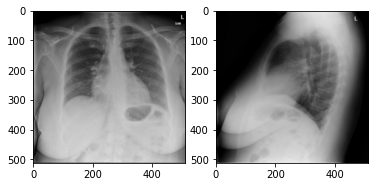

Prediction: heart size normal lung clear no edema effusion
Caption: heart size normal lung clear no edema effusion



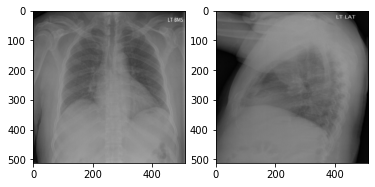

Prediction: low lung volume without acute cardiopulmonary disease
Caption: low lung volume without acute cardiopulmonary disease



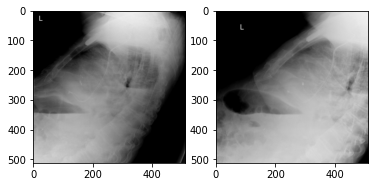

Prediction: cardiomegaly airspace disease disease pleural effusion right left
Caption: cardiomegaly bibasilar airspace disease bilateral pleural effusion right great left



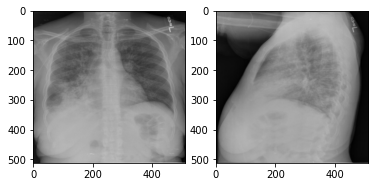

Prediction: right pleural pneumonia
Caption: multifocal right side pneumonia



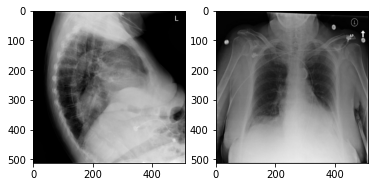

Prediction: heart size cardiopulmonary no active pulmonary edema pneumonia xxxx
Caption: borderline heart size calcify aorta no active pulmonary edema lobar pneumonia probable large retrocardiac hiatal hernia



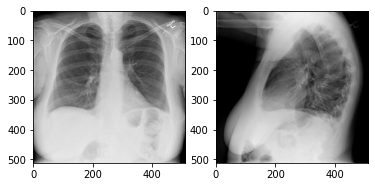

Prediction: mild left disease mild atelectasis scar
Caption: mild blunting left costophrenic recess possibly mild atelectasis scar



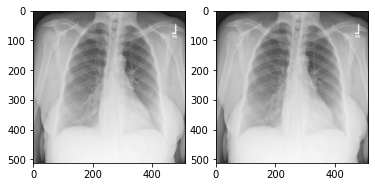

Prediction: no acute pulmonary disease
Caption: no acute pulmonary disease



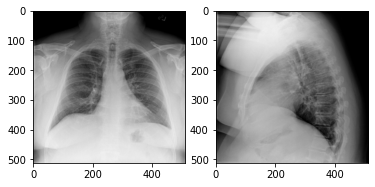

Prediction: no radiographic evidence acute
Caption: no radiographic evidence thoracic metastasis



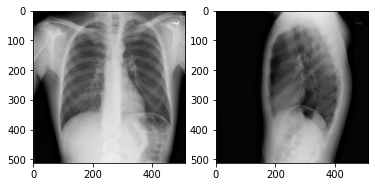

Prediction: no acute finding
Caption: no acute finding



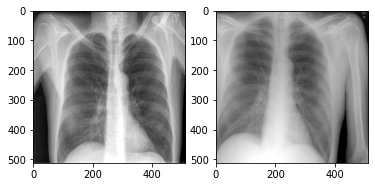

Prediction: chest right right no acute cardiopulmonary abnormality right xxxx
Caption: chest right shoulder no acute cardiopulmonary abnormality negative right shoulder fracture dislocation



In [16]:
scnn_model = BaseModel(train_df,test_df, "/content/gdrive/MyDrive/image", LENGTH, tokenizer.vocab_size, 20, "SCNN")
scnn_model.train()
for _ in range(20):
    scnn_model.sample(tokenizer)
    print()
scnn_model.evaluate(tokenizer)


Epoch 0 Train Loss 5.265236642009528 Validation Loss 3.4163483995379824
Epoch 1 Train Loss 2.3770690777505092 Validation Loss 1.680340293681983
Epoch 2 Train Loss 1.41905602651049 Validation Loss 1.2094736604979544
Epoch 3 Train Loss 1.1229119148365287 Validation Loss 1.0232248703638713
Epoch 4 Train Loss 0.9671884063602418 Validation Loss 0.8914999221310471
Epoch 5 Train Loss 0.8551645944284838 Validation Loss 0.8174134122602867
Epoch 6 Train Loss 0.7686163152373114 Validation Loss 0.7759119615410314
Epoch 7 Train Loss 0.696251918410146 Validation Loss 0.6716308097044627
Epoch 8 Train Loss 0.6385854452617409 Validation Loss 0.6070329438556324
Epoch 9 Train Loss 0.5858954623226047 Validation Loss 0.556377855665756
Epoch 10 Train Loss 0.5405507433091024 Validation Loss 0.5114662114417914
Epoch 11 Train Loss 0.5013839514680611 Validation Loss 0.4820523460706075
Epoch 12 Train Loss 0.4674961376328801 Validation Loss 0.44522230101354193
Epoch 13 Train Loss 0.4390701488700024 Validation Los

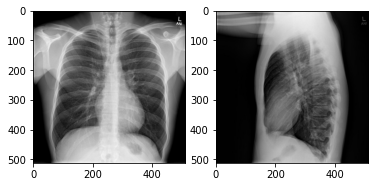

Prediction: no evidence active disease
Caption: no evidence active disease



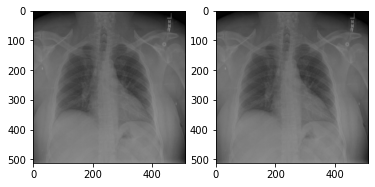

Prediction: no acute disease
Caption: no acute disease



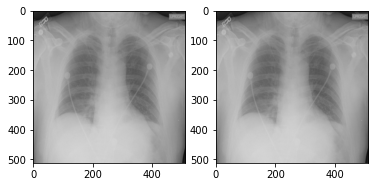

Prediction: identify no right pneumothorax acute atelectasis airspace disease
Caption: previously identify small right pneumothorax not visualize today exam minimal bibasilar atelectasis airspace disease



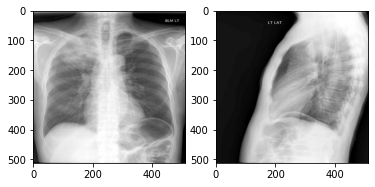

Prediction: acute no right right xxxx acute xxxx xxxx lung pneumonia
Caption: worsen masslike opacification right apex suggest worsen malignancy malignancy postobstructive pneumonia



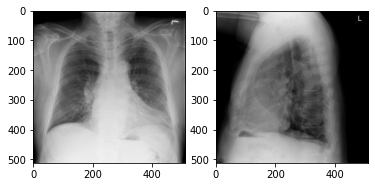

Prediction: no acute finding
Caption: no acute finding



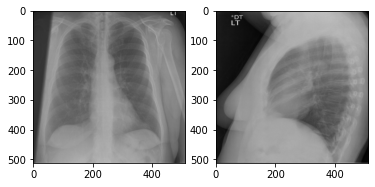

Prediction: no active disease
Caption: no active disease



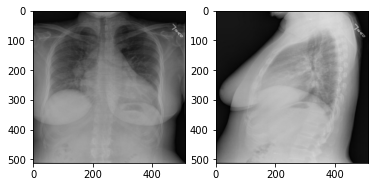

Prediction: right effusion size acute silhouette acute pulmonary radiographic cardiomegaly disease effusion pulmonary pulmonary no active no radiographic radiographic mediastinal xxxx xxxx mass finding chest recommend heart finding
Caption: moderate increase size cardiac silhouette unclear whether secondary cardiomegaly pericardial effusion pulmonary vascular congestion widen mediastinum maybe secondary prominent mediastinal fat tortuous xxxx however adenopathy mass not exclude ct chest contrast recommend evaluation finding



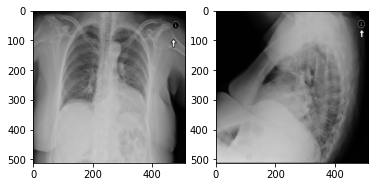

Prediction: left basilar opacity may represent atelectasis
Caption: left basilar patchy opacity may represent atelectasis infection



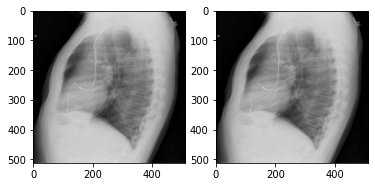

Prediction: no evidence acute cardiopulmonary disease
Caption: no evidence acute cardiopulmonary disease



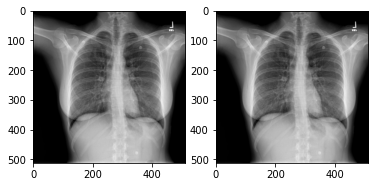

Prediction: no acute radiographic cardiopulmonary process
Caption: no acute radiographic cardiopulmonary process



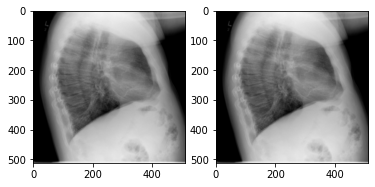

Prediction: normal heart size xxxx left lung base otherwise clear lung lung right
Caption: normal heart size xxxx scar left lung base otherwise clear lung reconstruct right clavicle



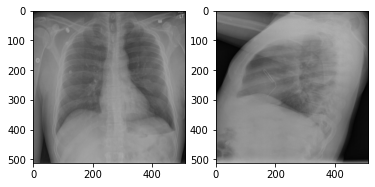

Prediction: acute size left pneumothorax xxxx xxxx left upper low lobe small left pleural effusion pleural
Caption: increase size left pneumothorax xxxx partial collapse left upper low lobe small left pleural effusion hemothorax



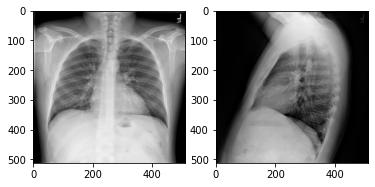

Prediction: no chest x xxxx xxxx clear lung mediastinal contour within normal limit no acute cardiopulmonary abnormality identify
Caption: no comparison chest x xxxx well expand clear lung mediastinal contour within normal limit no acute cardiopulmonary abnormality identify



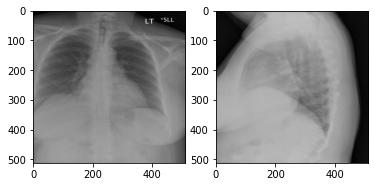

Prediction: chest no acute cardiopulmonary left left change no acute cardiopulmonary abnormality
Caption: chest no acute cardiopulmonary find left knee minimal degenerative change however no acute bony abnormality



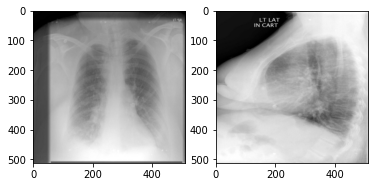

Prediction: right pleural acute airspace disease disease disease pneumonia may normal
Caption: right basal acute airspace disease please correlate clinically pneumonia chronic interstitial pattern may reflect copd



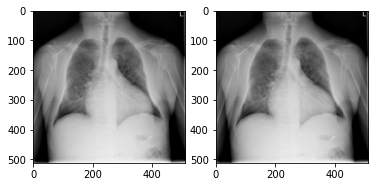

Prediction: cardiomegaly mild no change
Caption: cardiomegaly mild vascular prominence no change



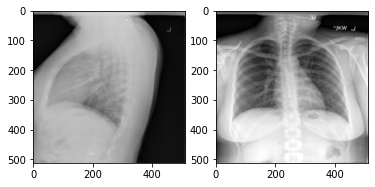

Prediction: no acute disease
Caption: no acute disease



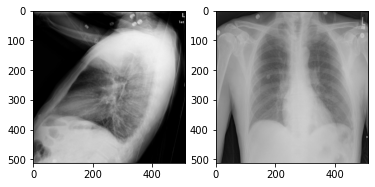

Prediction: no acute cardiopulmonary abnormality
Caption: no acute cardiopulmonary abnormality



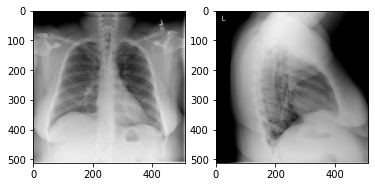

Prediction: no acute acute finding
Caption: no acute preoperative finding



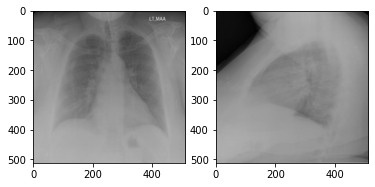

Prediction: no acute radiographic cardiopulmonary process
Caption: no acute radiographic cardiopulmonary process



/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'docs.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'docs.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doc-14-30-docs.googleusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/usr/local/lib/python3.7/

0.027414646248795197

In [ ]:
vgg_model = BaseModel(train_df,test_df, "/content/gdrive/MyDrive/Colab Notebooks/image", LENGTH, tokenizer.vocab_size, 20, "VGG")
vgg_model.train()
for _ in range(3):
    vgg_model.sample(tokenizer)
    print()
vgg_model.evaluate(tokenizer)


In [ ]:
dn_model = BaseModel(train_df,test_df, "/content/gdrive/MyDrive/Colab Notebooks/image", LENGTH, tokenizer.vocab_size, 20, "DenseNet")
dn_model.train()
for _ in range(3):
    dn_model.sample(tokenizer)
dn_model.evaluate(tokenizer)


In [ ]:
chex_model = BaseModel(train_df,test_df, "/content/gdrive/MyDrive/Colab Notebooks/image", LENGTH, tokenizer.vocab_size, 20, "ChexNet")
chex_model.train()
for _ in range(3):
    chex_model.sample(tokenizer)
chex_model.evaluate(tokenizer)